## To show this notebook as a slideshow, after downloading this notebook, change to the directory you have store the file in and type the following into the terminal/console:

jupyter nbconvert Random_forest.ipynb --to slides --post serve

## Obligatory dependencies

In [1]:
# importing dependencies
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt

# For model building
from sklearn.model_selection import train_test_split, cross_val_score

# Models
from sklearn.ensemble import RandomForestRegressor

# This notebook builds a random forest decision tree for prediction daily ride patterns.

## Loading in of the data

In [2]:
# Load in the data
#weather = pd.read_csv("~/Projects/NiceRide/Weather_data/01012010_12312017.csv") # Weather data
weather = pd.read_csv('/home/gilmore/NiceRideMN/Weather_data/01012010_12312017.csv') # weather alt

temp = []
for x in [2013 + x for x in range(5)] :
    #x = pd.read_csv("~/Projects/NiceRide/Nice_Ride_data/"+str(x)+"/NiceRide_trip_history_"+str(x)+".csv")
    x = pd.read_csv('/home/gilmore/NiceRideMN/Nice_Ride_data/'+str(x)+'/NiceRide_trip_history_'+str(x)+'.csv')
    temp.append(x)
    nr = pd.concat(temp)

## Changing the datetime objects to datetime variables

In [3]:
weather['DATE'] = weather['DATE'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

nr['Start_date'] = nr['Start_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
nr['End_date'] = nr['End_date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))

## Preparing the data to be used for the model
* Using datetime variable rides will be grouped by:
 * Daily count.
 * Mean ride duration

In [4]:
# Resampling our NR data so it takes the start date and Total duration, returns a count of rides per day 'daily_totals'

daily_totals = nr[['Start_date', 'duration']].resample('D', on='Start_date').count()
daily_totals = daily_totals.drop('Start_date', axis=1)
daily_totals = daily_totals.reset_index()
daily_totals = daily_totals.rename(index=str, columns={"duration": "daily_count",'Start_date':'DATE'})

In [5]:
daily_means = nr[['Start_date', 'duration']].resample('D', on='Start_date').mean()
daily_means = daily_means.reset_index()
daily_means = daily_means.rename(index=str, columns={"duration": "daily_mean",'Start_date':'DATE'})

## Correcting missing data in the weather dataframe
* From 2010-2013 There isn't TAVG this will be ameliorated by using the mean of TMIN and TMAX

In [6]:
# Changing TAVG-NAN values to the mean of the TMAX and TMIN
weather = weather.fillna(value={'TAVG': weather[weather.TAVG.isna()][['TMAX', 'TMIN']]
                                .agg("mean", axis="columns")})

In [7]:
## Dropping columns that won't be used in the analysis.

In [8]:
weather = weather.drop(['STATION', 'NAME'], axis=1)

## Now though our data is corrected for the analysis it will be merged together

In [9]:
temp = weather.merge(daily_totals, how='outer',on='DATE')
temp = temp.merge(daily_means, how='outer',on='DATE')
temp.info()
temp.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 10 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    1761 non-null float64
daily_mean     1080 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 251.1 KB


,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,NaN,NaN
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,NaN,NaN
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,NaN,NaN
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,NaN,NaN
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,NaN,NaN


In [10]:
# Notice how the count of DCOUNT varies from what the other columns have
features = temp.fillna(value=0,axis=0) # Where we don't have a daily count (Dcount) fill this with zeros instead
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 10 columns):
DATE           2922 non-null datetime64[ns]
AWND           2922 non-null float64
PRCP           2922 non-null float64
SNOW           2922 non-null float64
SNWD           2922 non-null int64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    2922 non-null float64
daily_mean     2922 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 251.1 KB


## This next section will change our date column from dtype datetime into seperate numerical relevant date colummns

In [11]:
features['YEAR'] = features['DATE'].dt.year
features['MONTH'] = features['DATE'].dt.month
features['DAY'] = features['DATE'].dt.day

In [12]:
features.head(5) # Three new, seperate, columns that identify year, month, day

,DATE,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY
0,2010-01-01,8.95,0.0,0.0,9,-1.5,6,-9,0.0,0.0,2010,1,1
1,2010-01-02,4.03,0.0,0.0,9,-7.0,1,-15,0.0,0.0,2010,1,2
2,2010-01-03,2.91,0.0,0.0,9,-3.5,7,-14,0.0,0.0,2010,1,3
3,2010-01-04,5.59,0.0,0.0,9,-1.5,7,-10,0.0,0.0,2010,1,4
4,2010-01-05,3.13,0.0,0.0,9,0.5,10,-9,0.0,0.0,2010,1,5


# Feature engineering to create variables:
* Weekday or weekend
* Summer or not summer

In [13]:
# Create a weekday variable column Mon = 0, Sun = 6
features['WEND'] = features['DATE'].dt.weekday

# Adjust WEND column to be catagorical; If it's a weekday WEND = 0 else if weekend WEND = 1
features['WEND'] = features['WEND'].apply(lambda x:1 if x>4 else 0)

In [14]:
# Random forests can't use datetime objects
features = features.drop('DATE', axis=1)
features = features.drop(['SNWD', 'SNOW'], axis=1)

# Checking our dataset prior to data splits

In [15]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2922 entries, 0 to 2921
Data columns (total 11 columns):
AWND           2922 non-null float64
PRCP           2922 non-null float64
TAVG           2922 non-null float64
TMAX           2922 non-null int64
TMIN           2922 non-null int64
daily_count    2922 non-null float64
daily_mean     2922 non-null float64
YEAR           2922 non-null int64
MONTH          2922 non-null int64
DAY            2922 non-null int64
WEND           2922 non-null int64
dtypes: float64(5), int64(6)
memory usage: 273.9 KB


# Splitting the data on days with Daily Counts and without

In [16]:
# Seperating our data sets
winter_features = features[features['daily_count'] == 0].reset_index(drop=True)

# Need to drop all days where there where no rides taken (Dcount = 0)
features = features[features['daily_count'] != 0].reset_index(drop=True)

In [17]:
features.describe()

,AWND,PRCP,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND
count,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000,1080.000000
mean,9.101806,0.133750,62.422685,71.354630,53.541667,1939.222222,2541.934202,2014.995370,7.072222,15.802778,0.285185
std,3.320652,0.357112,12.925530,13.925633,12.531485,908.160793,11111.184380,1.424978,2.073346,8.857590,0.451712
min,0.890000,0.000000,8.000000,19.000000,-3.000000,1.000000,11.000000,2013.000000,1.000000,1.000000,0.000000
25%,6.710000,0.000000,54.000000,63.000000,44.000000,1302.250000,1142.270481,2014.000000,5.000000,8.000000,0.000000
50%,8.720000,0.000000,65.000000,75.000000,56.000000,1957.500000,1492.317172,2015.000000,7.000000,16.000000,0.000000
75%,11.410000,0.070000,72.000000,82.000000,63.000000,2598.000000,1987.761163,2016.000000,9.000000,23.250000,1.000000
max,21.250000,4.130000,87.000000,98.000000,80.000000,5625.000000,330526.000000,2017.000000,11.000000,31.000000,1.000000


## DCOUNT shows Minimum of at least 1, and the

## I'm concerned why month shows min 1; there shouldn't be any data for January. Time to investigate further

In [18]:
features[features.MONTH == 1]

,AWND,PRCP,TAVG,TMAX,TMIN,daily_count,daily_mean,YEAR,MONTH,DAY,WEND
0,10.29,0.28,31.5,39,24,1.0,106.0,2013,1,10,0


## Albeit rare, above freezing in January can happen in Minnesota

# Features, Targets, and converting Data in arrays for performance optimization

# Feature (variable) and Target (Daily rides) creation

In [19]:
# Saving the target/label variable and removing from features Dataframe
target = features.daily_count.values
feat = features.drop('daily_count', axis=1).values

# Saving the feature names for future use
feature_names = list(features.drop('daily_count', axis=1).columns)

# Splitting our data for training and testing

In [20]:
# Splitting the data into training and test sets
X, X_test, y, y_test = train_test_split(feat, target, test_size=.25, random_state=42)

### Inspecting the shape of the features and labels

In [21]:
print('Training Features shape', X.shape)
print('Training labels shape', y.shape)

print('Testing Features shape', X_test.shape)
print('Testing labels shape', y_test.shape)

Training Features shape (810, 10)
Training labels shape (810,)
Testing Features shape (270, 10)
Testing labels shape (270,)


# Training the data

In [22]:
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators=75, random_state=42)

rf.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=75, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

# Making predictions on the test set

In [23]:
predictions = rf.predict(X_test)

# Assessing the performance of our RandomForestRegressor

This is the r2 score

In [24]:
cv_r2 = cross_val_score(rf, X, y, cv=10)
print(cv_r2)
print(np.mean(cv_r2))

[0.808219   0.78961272 0.76948841 0.77024683 0.73248238 0.81005257
 0.82266589 0.83004795 0.84027589 0.83084905]
0.8003940688916138


In [25]:
cv_negMSElog_error = cross_val_score(rf, X, y, scoring='neg_mean_squared_log_error', cv=5)
print(cv_negMSElog_error)
print(np.mean(cv_negMSElog_error))

[-0.24708576 -0.20121777 -0.17916109 -0.23258576 -0.12319635]
-0.19664934630502617


In [26]:
errors = abs(predictions - y_test)

print('Mean Absolute Error: ', round(np.mean(errors), 2))

Mean Absolute Error:  302.32


In [27]:
# Calculating the Mean Absolute Percentage Error (MAPE)
mape = 100 * (errors / y_test)

accuracy = 100 - np.mean(mape)
print('Accuracy: ', np.round(accuracy, 2), '%')

Accuracy:  67.35 %


In [28]:
(errors == y_test).mean()

0.0

In [29]:
# Mean Absolute Square

# Looking at the feature importance to the decision tree model

In [30]:
# Get numerical feature importances
importances = list(rf.feature_importances_)

# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_names, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: TMAX                 Importance: 0.6
Variable: daily_mean           Importance: 0.12
Variable: PRCP                 Importance: 0.08
Variable: YEAR                 Importance: 0.04
Variable: MONTH                Importance: 0.04
Variable: AWND                 Importance: 0.03
Variable: DAY                  Importance: 0.03
Variable: TAVG                 Importance: 0.02
Variable: TMIN                 Importance: 0.02
Variable: WEND                 Importance: 0.02


## Visualizing the feature importances

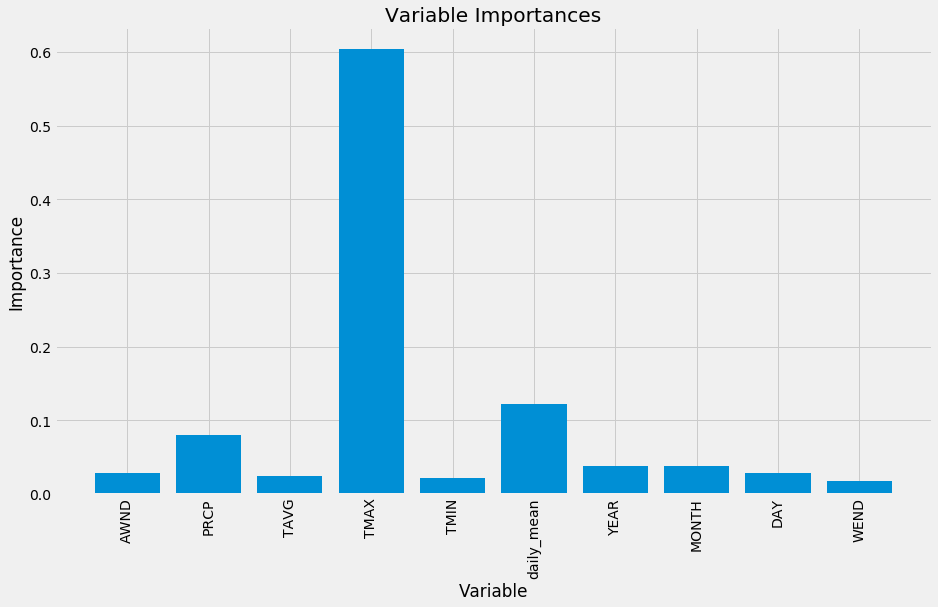

In [31]:
# Set the style
plt.style.use('fivethirtyeight')

plt.figure(figsize=[14,8])

# list of x locations for plotting
x_values = list(range(len(importances)))

# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# Tick labels for x axis
plt.xticks(x_values, feature_names, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

# Graphing the emperical data and the predictions
* This will be presented as:
 * Emperical as a line graph
 * Predictions will be as a 'o' marker

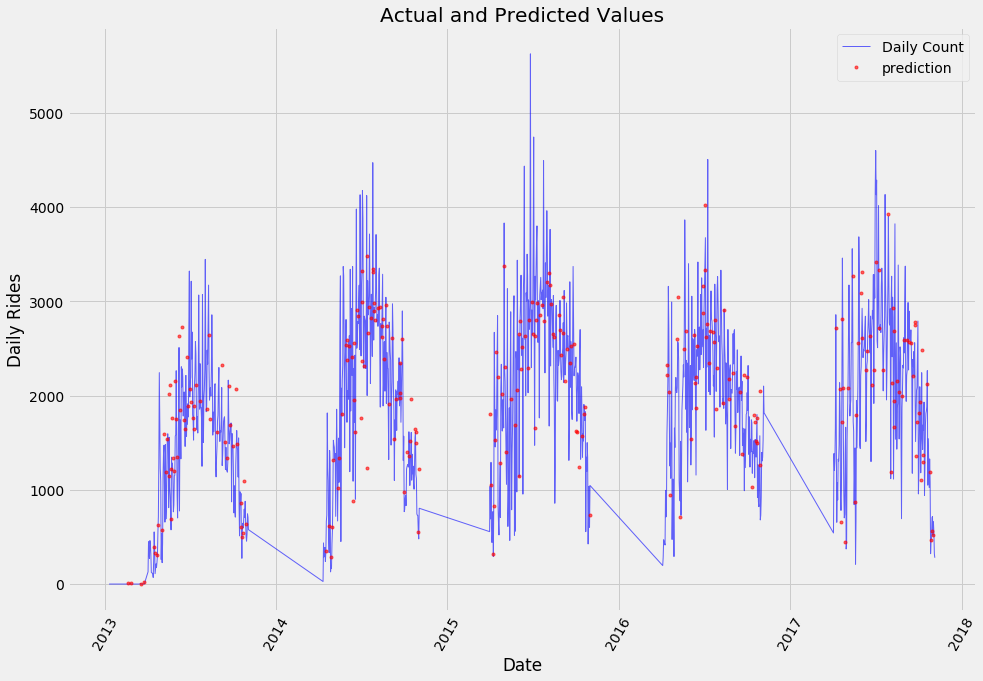

In [32]:
# Dates of training values
days = feat[:, feature_names.index('DAY')]
months = feat[:, feature_names.index('MONTH')]
years = feat[:, feature_names.index('YEAR')]

# List and then convert to datetime object
dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'date': dates, 'DCOUNT': target})

# Dates of predictions
months = X_test[:, feature_names.index('MONTH')]
days = X_test[:, feature_names.index('DAY')]
years = X_test[:, feature_names.index('YEAR')]

# Column of dates
test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]

# Convert to datetime objects
test_dates = [dt.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})

# Plot the actual values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['date'], true_data['DCOUNT'], 'b', label = 'Daily Count', linewidth=1, alpha=.6)

# Plot the predicted values
plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction', markersize=3, alpha=.6)
plt.xticks(rotation = '60'); 
plt.legend()

# Graph labels
plt.xlabel('Date'); plt.ylabel('Daily Rides'); plt.title('Actual and Predicted Values');

# Scatter plot of: 
* Emperical Data vs Max temperature (highest feature)
* Prediction data vs Max temperature

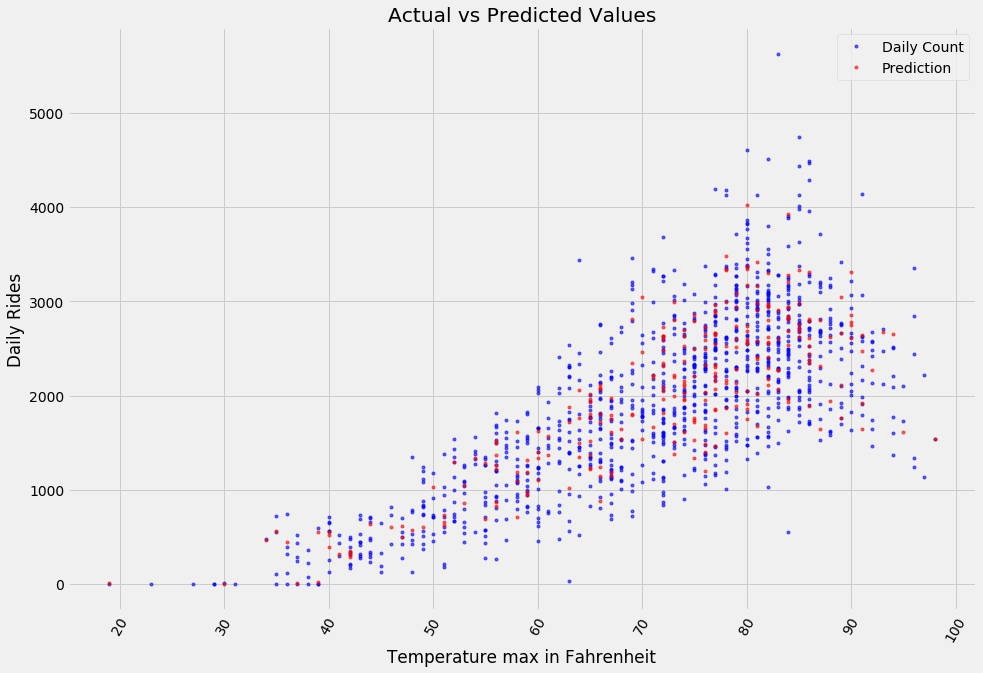

In [33]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'TMAX': features.TMAX.values, 'DCOUNT': target})

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'TMAX': X_test[:,3], 'prediction': predictions})

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['TMAX'], true_data['DCOUNT'], 'bo', label = 'Daily Count', markersize=3, alpha=.6)
plt.plot(predictions_data['TMAX'], predictions_data['prediction'], 'ro', label = 'Prediction', markersize=3, alpha=.6)

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual vs Predicted Values');

# Previous graph with linear models included

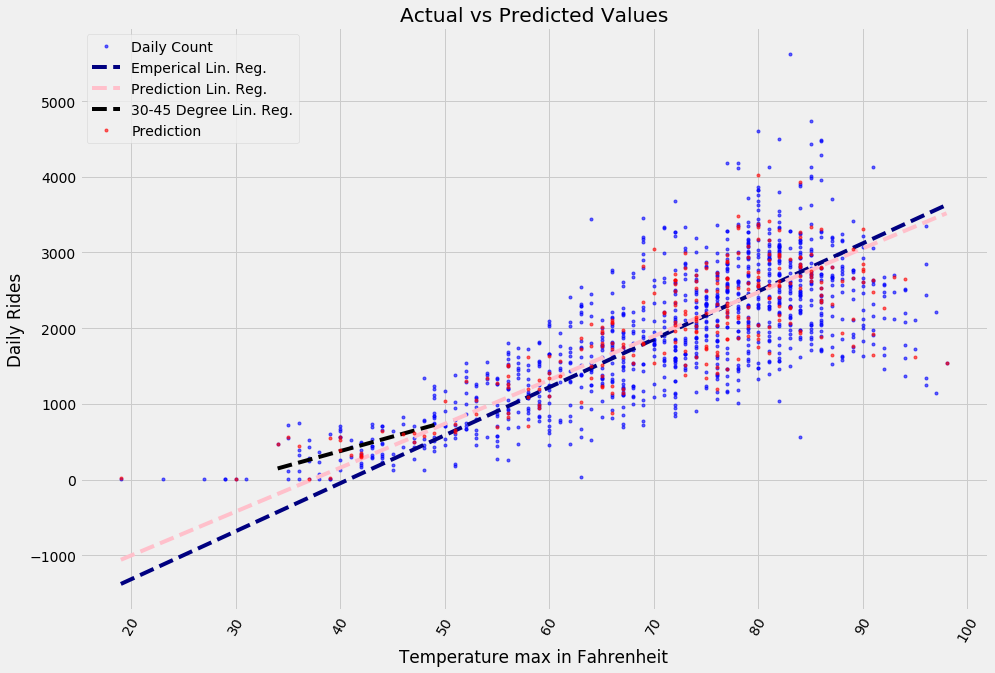

In [34]:
# Dataframe with true values and dates
true_data = pd.DataFrame(data = {'TMAX': features.TMAX.values, 'daily_count': target}) 

# Plot the actual values and predicted values
plt.figure(figsize=(14.5,10))
plt.plot(true_data['TMAX'], true_data['daily_count'], 'bo', label = 'Daily Count', markersize=3, alpha=.6)

x = sorted(true_data['TMAX'].values) 
y = sorted(true_data['daily_count'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x), '--k', color='navy', label='Emperical Lin. Reg.')

x = sorted(predictions_data['TMAX'].values) 
y = sorted(predictions_data['prediction'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x), '--k', color='pink', label='Prediction Lin. Reg.')

low_temp = predictions_data[(predictions_data['TMAX'] > 30) & (predictions_data['TMAX'] < 50)]
x = sorted(low_temp['TMAX'].values)
y = sorted(low_temp['prediction'].values)
fit = np.polyfit(x, y, 1) 
fit_fn = np.poly1d(fit) 
plt.plot(x, fit_fn(x), '--k', color='black', label='30-45 Degree Lin. Reg.')

# Dataframe with predictions and dates
predictions_data = pd.DataFrame(data = {'TMAX': X_test[:,3], 'prediction': predictions})

# Plot the actual values and predicted values
plt.plot(predictions_data['TMAX'], predictions_data['prediction'], 'ro', label = 'Prediction', markersize=3, alpha=.6)

plt.xticks(rotation = '60'); 
plt.legend()
plt.xlabel('Temperature max in Fahrenheit'); plt.ylabel('Daily Rides'); plt.title('Actual vs Predicted Values');